In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import math

In [3]:
def simular_chegada_propostas(dias=2):
    print("A simular dados de entrada...")
    total_horas = dias * 24
    datas = pd.to_datetime(pd.date_range(start='2025-09-01 00:00:00', periods=total_horas, freq='h'))
    probabilidade_chegada = np.sin(np.linspace(0, 2 * np.pi, 24)) * 0.5 + 0.6
    probabilidade_chegada = np.tile(probabilidade_chegada, dias)
    num_propostas_por_hora = np.random.poisson(probabilidade_chegada * 270)
    lista_propostas = []
    for data, num_propostas in zip(datas, num_propostas_por_hora):
        for _ in range(num_propostas):
            minuto_aleatorio = np.random.randint(0, 60)
            segundo_aleatorio = np.random.randint(0, 60)
            timestamp_proposta = data + pd.Timedelta(minutes=minuto_aleatorio, seconds=segundo_aleatorio)
            lista_propostas.append({'data_entrada': timestamp_proposta})
    df = pd.DataFrame(lista_propostas)
    print(f"Total de {len(df)} propostas simuladas.")
    return df

df_propostas = simular_chegada_propostas(dias=2)

A simular dados de entrada...
Total de 7788 propostas simuladas.


In [14]:
TMA_MINUTOS = 5 # Definindo o TMA de forma clara aqui

# --- 2. Preparação dos dados (COM CÁLCULO DE ANALISTAS) ---
df_propostas['data_entrada'] = pd.to_datetime(df_propostas['data_entrada'])
df_propostas['data_sla'] = df_propostas['data_entrada'] + pd.Timedelta(hours=12)
df_propostas['data_inicio_limite'] = df_propostas['data_sla'] - pd.Timedelta(minutes=TMA_MINUTOS)

entradas_por_hora = df_propostas.groupby(pd.Grouper(key='data_entrada', freq='30min')).size().rename('entradas')
inicio_propostas_tma = df_propostas.groupby(pd.Grouper(key='data_inicio_limite', freq='30min')).size().rename('inicio_limite')
vencimentos_por_hora = df_propostas.groupby(pd.Grouper(key='data_sla', freq='30min')).size().rename('vencimentos_sla')

df_analise = pd.concat([entradas_por_hora, inicio_propostas_tma, vencimentos_por_hora], axis=1).fillna(0)

# PASSO NOVO: Calcular o número de analistas necessários
# A função lambda aplica o cálculo a cada valor da coluna 'inicio_limite'
df_analise['analistas_necessarios'] = df_analise['inicio_limite'].apply(
    lambda x: math.ceil((x * TMA_MINUTOS) / 30)
)
print("Tabela de análise final com necessidade de analistas:")

# --- 3. Geração do Gráfico Final (com Hover Personalizado) ---
print("A gerar o gráfico final com hover de 5 minutos...")
fig = go.Figure()

# Camada 1: ÁREA DE ENTRADAS
fig.add_trace(go.Scatter(
    name='Entradas', 
    x=df_analise.index, 
    y=df_analise['entradas'], 
    fill='tozeroy', 
    fillcolor='rgba(24, 102, 215, 0.4)', 
    line_width=0.5,
    hovertemplate='<b>%{x|%d/%m %H:%M}</b><br>Entradas: %{y}<extra></extra>'
))

# Camada 2: ÁREA DE VENCIMENTOS
fig.add_trace(go.Scatter(
    name='Vencimento SLA', 
    x=df_analise.index, 
    y=df_analise['vencimentos_sla'], 
    fill='tozeroy', 
    fillcolor='rgba(220, 20, 60, 0.3)', 
    line_width=0.5,
    hovertemplate='<b>%{x|%d/%m %H:%M}</b><br>Vencimentos: %{y}<extra></extra>'
))

# Camada 3: LINHA DE AÇÃO
fig.add_trace(go.Scatter(
    name='AÇÃO: Início Limite', 
    x=df_analise.index, 
    y=df_analise['inicio_limite'], 
    line=dict(width=3.5, color='darkorange'),
    hovertemplate='<b>%{x|%d/%m %H:%M}</b><br>Início Limite: %{y}<extra></extra>'
))

# Camada 4: LINHA DE BOLINHAS PARA ANALISTAS
fig.add_trace(go.Scatter(
    x=df_analise.index,
    y=df_analise['analistas_necessarios'],
    name='Analistas Necessários',
    mode='lines+markers',
    line=dict(color='green', width=2, dash='dot'),
    marker=dict(size=8),
    yaxis='y2',
    hovertemplate='<b>%{x|%d/%m %H:%M}</b><br>Analistas: %{y}<extra></extra>'
))

# Configura o layout (sem alterações aqui)
fig.update_layout(
    title='Planeamento de Capacidade: Fluxo de Propostas vs. Analistas Necessários (5 min)',
    xaxis_title='Data e Hora',
    template='plotly_white',
    legend=dict(x=0.01, y=0.98),
    yaxis=dict(title='Número de Propostas'),
    yaxis2=dict(
        title='Nº de Analistas Necessários',
        overlaying='y',
        side='right',
        showgrid=False,
        range=[0, df_analise['analistas_necessarios'].max() * 1.2]
    ),
    xaxis=dict(dtick=1000 * 60 * 60 * 2, tickformat='%d/%m\n%Hh', tickmode='linear')
)

fig.show()

Tabela de análise final com necessidade de analistas:
A gerar o gráfico final com hover de 5 minutos...


A simular dados de entrada...
Total de 7864 propostas simuladas.
A preparar dados para o KDE...
Exemplo dos dados reestruturados (formato longo):
    Evento  Minuto
0  Entrada      30
1  Entrada      55
2  Entrada      11
3  Entrada       6
4  Entrada      36
A gerar o gráfico de densidade (KDE)...


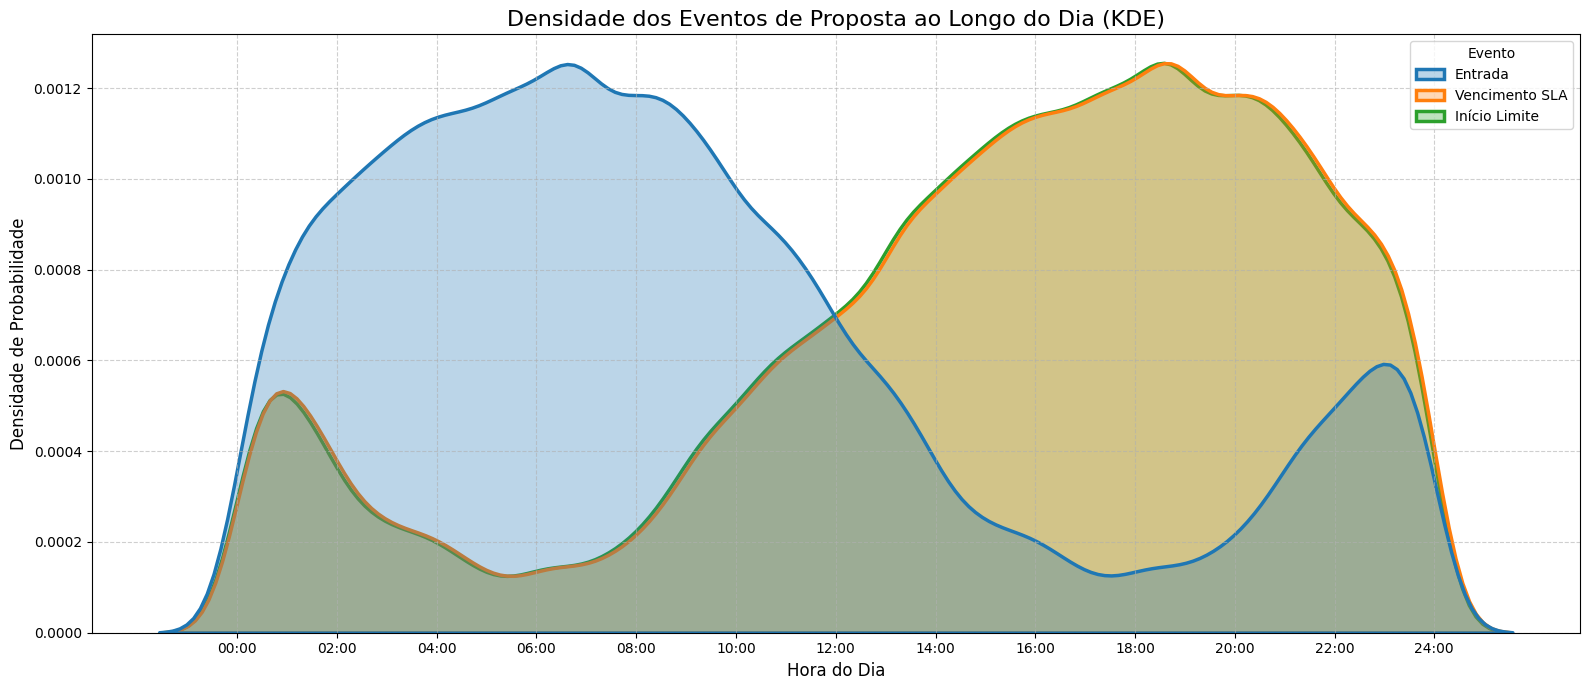

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Simulação de Dados (sem alterações) ---
# (Pode reutilizar o df_propostas gerado no passo anterior ou executar novamente)

TMA_MINUTOS = 5 # Usando 5 minutos como no seu exemplo anterior

def simular_chegada_propostas(dias=2):
    print("A simular dados de entrada...")
    total_horas = dias * 24
    datas = pd.to_datetime(pd.date_range(start='2025-09-01 00:00:00', periods=total_horas, freq='h'))
    probabilidade_chegada = np.sin(np.linspace(0, 2 * np.pi, 24)) * 0.5 + 0.6
    probabilidade_chegada = np.tile(probabilidade_chegada, dias)
    num_propostas_por_hora = np.random.poisson(probabilidade_chegada * 270)
    lista_propostas = []
    for data, num_propostas in zip(datas, num_propostas_por_hora):
        for _ in range(num_propostas):
            minuto_aleatorio = np.random.randint(0, 60)
            segundo_aleatorio = np.random.randint(0, 60)
            timestamp_proposta = data + pd.Timedelta(minutes=minuto_aleatorio, seconds=segundo_aleatorio)
            lista_propostas.append({'data_entrada': timestamp_proposta})
    df = pd.DataFrame(lista_propostas)
    print(f"Total de {len(df)} propostas simuladas.")
    return df

df_propostas = simular_chegada_propostas(dias=2)

# --- 2. Preparação dos dados para o KDE Múltiplo ---
print("A preparar dados para o KDE...")
# Passo 2.1: Calcular todas as colunas de data
df_propostas['data_entrada'] = pd.to_datetime(df_propostas['data_entrada'])
df_propostas['data_sla'] = df_propostas['data_entrada'] + pd.Timedelta(hours=12)
df_propostas['data_inicio_limite'] = df_propostas['data_sla'] - pd.Timedelta(minutes=TMA_MINUTOS)

# Passo 2.2: Converter cada data para o "minuto do dia" (0-1439)
df_propostas['Entrada'] = df_propostas['data_entrada'].dt.hour * 60 + df_propostas['data_entrada'].dt.minute
df_propostas['Vencimento SLA'] = df_propostas['data_sla'].dt.hour * 60 + df_propostas['data_sla'].dt.minute
df_propostas['Início Limite'] = df_propostas['data_inicio_limite'].dt.hour * 60 + df_propostas['data_inicio_limite'].dt.minute

# Passo 2.3: Reestruturar (Melt) os dados para o formato "longo"
# Isto é ideal para o seaborn: uma coluna identifica o evento, outra o valor.
df_melted = pd.melt(
    df_propostas,
    value_vars=['Entrada', 'Vencimento SLA', 'Início Limite'], # Colunas a transformar em linhas
    var_name='Evento', # Nome da nova coluna que armazena os nomes das antigas colunas
    value_name='Minuto' # Nome da nova coluna que armazena os valores
)

print("Exemplo dos dados reestruturados (formato longo):")
print(df_melted.head())

# --- 3. Geração do Gráfico KDE ---
print("A gerar o gráfico de densidade (KDE)...")

plt.figure(figsize=(16, 7))
ax = sns.kdeplot(
    data=df_melted,
    x='Minuto',
    hue='Evento', # Cria uma curva para cada categoria na coluna 'Evento'
    fill=True,
    common_norm=False, # Garante que cada curva é normalizada independentemente
    alpha=0.3, # Nível de transparência das áreas
    linewidth=2.5,
    bw_adjust=0.5
)

# --- 4. Formatação e Melhoria do Gráfico ---
ax.set_title('Densidade dos Eventos de Proposta ao Longo do Dia (KDE)', fontsize=16)
ax.set_xlabel('Hora do Dia', fontsize=12)
ax.set_ylabel('Densidade de Probabilidade', fontsize=12)

# Melhora os marcadores do eixo X para mostrar as horas
horas = range(0, 25, 2) # Marcas a cada 2 horas
ax.set_xticks([h * 60 for h in horas])
ax.set_xticklabels([f'{h:02d}:00' for h in horas])
ax.grid(linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# --- 4. Criação do Gráfico (CÓDIGO MODIFICADO) ---
# Objetivo: Criar um gráfico com área para entradas e linhas para as métricas de ação.

print("A gerar o novo gráfico de área...")
fig, ax = plt.subplots(figsize=(20, 8))

# Plotar as entradas como uma ÁREA PREENCHIDA
ax.fill_between(df_analise.index, df_analise['entradas'], color="skyblue", alpha=0.4, label='Fluxo de Entrada de Propostas (Volume)')

# Plotar as métricas de ação como LINHAS por cima da área
ax.plot(df_analise.index, df_analise['vencimento_sla'], color='red', marker='o', linestyle=':', markersize=5, label='Vencimento do SLA (Risco Final)')
ax.plot(df_analise.index, df_analise['inicio_limite'], color='darkorange', marker='', linestyle='-', linewidth=2.5, label=f'Ação Requerida: Início Limite (SLA - {TMA_MINUTOS} min)')

# --- Destaque do Horário de Operação (7:00 às 22:00) ---
for data in df_analise.index:
    if 7 <= data.hour < 22:
        ax.axvspan(data, data + pd.Timedelta(hours=1), facecolor='green', alpha=0.1, zorder=0)

# Formatação e legendas
ax.set_title('Análise de Fluxo de Trabalho e Pressão Operacional (48 Horas)', fontsize=16)
ax.set_xlabel('Data e Hora', fontsize=12)
ax.set_ylabel('Número de Propostas', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Melhorar a visualização do eixo Y, começando em zero
ax.set_ylim(bottom=0)

# Formatação do eixo X
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()